In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern, hog
from scipy.fftpack import dct
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import f1_score, classification_report

In [4]:
def load_images(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['real', 'fake']):  # real: 0, fake: 1
        path = os.path.join(folder_path, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (96, 96))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
train_path = 'deepfake_data/Dataset/Train'
test_path = 'deepfake_data/Dataset/Test'
val_path = 'deepfake_data/Dataset/Validation'

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)
X_val, y_val = load_images(val_path)

print("Train images:", X_train.shape, "Labels:", y_train.shape)
print("Test images:", X_test.shape, "Labels:", y_test.shape)
print("Validation images:", X_val.shape, "Labels:", y_val.shape)

Train images: (140002, 96, 96) Labels: (140002,)
Test images: (10905, 96, 96) Labels: (10905,)
Validation images: (39428, 96, 96) Labels: (39428,)


In [9]:

def extract_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (96, 96))  # تأكد من نفس المقاس

        # =======================
        # 1- HOG Features
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

        # =======================
        # 2- LBP Histogram Features
        lbp = local_binary_pattern(img, P=16, R=2, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, 11),
                                     range=(0, 10))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)

        # =======================
        # 3- Color Histogram Features
        img_color = cv2.cvtColor(cv2.merge([img, img, img]), cv2.COLOR_BGR2HSV)  # نحوله HSV
        hist_h = cv2.calcHist([img_color], [0], None, [8], [0, 180]).flatten()
        hist_s = cv2.calcHist([img_color], [1], None, [8], [0, 256]).flatten()
        hist_v = cv2.calcHist([img_color], [2], None, [8], [0, 256]).flatten()
        color_hist = np.hstack([hist_h, hist_s, hist_v])
        color_hist = color_hist / (color_hist.sum() + 1e-7)  # Normalization

        # =======================
        # 4- Frequency (DCT) Features
        dct_features = dct(dct(img.T, norm='ortho').T, norm='ortho')
        dct_features = dct_features.flatten()
        dct_features = dct_features[:500]  # ناخد أول 500 عنصر عشان الداتا متبقاش ضخمة جدًا

        # =======================
        # Combine All
        combined = np.hstack([hog_features, lbp_hist, color_hist, dct_features])
        features.append(combined)

    return np.array(features)


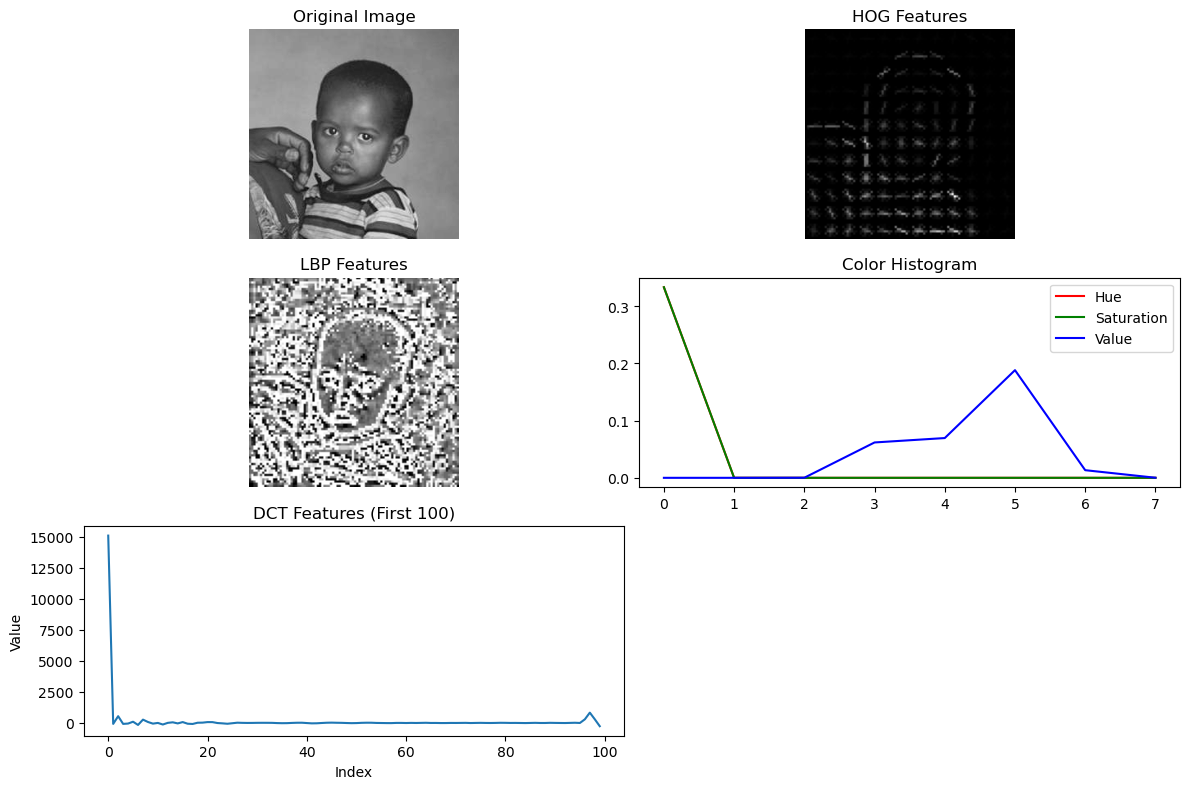

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from scipy.fftpack import dct

def extract_single_feature(img):
    img = cv2.resize(img, (96, 96))

    # 1- HOG
    hog_features, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

    # 2- LBP
    lbp = local_binary_pattern(img, P=16, R=2, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)

    # 3- Color Histogram
    img_color = cv2.cvtColor(cv2.merge([img, img, img]), cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([img_color], [0], None, [8], [0, 180]).flatten()
    hist_s = cv2.calcHist([img_color], [1], None, [8], [0, 256]).flatten()
    hist_v = cv2.calcHist([img_color], [2], None, [8], [0, 256]).flatten()
    color_hist = np.hstack([hist_h, hist_s, hist_v])
    color_hist = color_hist / (color_hist.sum() + 1e-7)

    # 4- DCT
    dct_features = dct(dct(img.T, norm='ortho').T, norm='ortho')
    dct_features = dct_features.flatten()[:500]

    # Combine All
    combined = np.hstack([hog_features, lbp_hist, color_hist, dct_features])
    
    return hog_image, lbp, lbp_hist, color_hist, dct_features, combined

def visualize_features(img):
    hog_img, lbp_img, lbp_hist, color_hist, dct_features, features = extract_single_feature(img)

    # ======= Visualization =======
    plt.figure(figsize=(12, 8))

    # 1. Original Image
    plt.subplot(3, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # 2. HOG Image
    plt.subplot(3, 2, 2)
    plt.imshow(hog_img, cmap='gray')
    plt.title("HOG Features")
    plt.axis('off')

    # 3. LBP Image
    plt.subplot(3, 2, 3)
    plt.imshow(lbp_img, cmap='gray')
    plt.title("LBP Features")
    plt.axis('off')

    # 4. Color Histogram (3 subplots for H, S, V)
    plt.subplot(3, 2, 4)
    plt.plot(color_hist[:8], color='r', label='Hue')
    plt.plot(color_hist[8:16], color='g', label='Saturation')
    plt.plot(color_hist[16:24], color='b', label='Value')
    plt.title("Color Histogram")
    plt.legend()

    # 5. DCT Features
    plt.subplot(3, 2, 5)
    plt.plot(dct_features[:100])  # First 100 DCT values
    plt.title("DCT Features (First 100)")
    plt.xlabel("Index")
    plt.ylabel("Value")

    plt.tight_layout()
    plt.show()

# ======= Load example image =======
sample_path = 'deepfake_data/Dataset/Test/Real/real_999.jpg'  # ← عدل المسار حسب مكان الصورة
img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

# استعراض الفيتشرز
visualize_features(img)


In [10]:



FEATURES_DIR = "features"
os.makedirs(FEATURES_DIR, exist_ok=True)

def save_or_load_features(split_name, X_split, extract_func):
    features_path = os.path.join(FEATURES_DIR, f"{split_name}_features.npy")

    if os.path.exists(features_path):
        print(f"🔵 {split_name} features already exist at {features_path}. Skipping extraction...")
        return None  
    else:
        print(f"🟡 Extracting {split_name} features...")
        
        features_list = []
        for x in tqdm(X_split, desc=f"Extracting {split_name}"):
            features_list.append(extract_func([x])[0])
        
        features = np.array(features_list)
        np.save(features_path, features)
        print(f"✅ Saved {split_name} features to {features_path}")
        return features

X_train_features = save_or_load_features("train", X_train, extract_features)
X_test_features = save_or_load_features("test", X_test, extract_features)
X_val_features = save_or_load_features("val", X_val, extract_features)


🔵 train features already exist at features\train_features.npy. Skipping extraction...
🔵 test features already exist at features\test_features.npy. Skipping extraction...
🔵 val features already exist at features\val_features.npy. Skipping extraction...


In [11]:
def load_features(split_name):
    features_path = os.path.join(FEATURES_DIR, f"{split_name}_features.npy")
    features = np.load(features_path)
    return features

# تحميلهم لما تحتاج
X_train_features = load_features("train")
X_test_features = load_features("test")
X_val_features = load_features("val")

print("Train features shape:", X_train_features.shape)
print("Test features shape:", X_test_features.shape)
print("Validation features shape:", X_val_features.shape)


Train features shape: (140002, 4890)
Test features shape: (10905, 4890)
Validation features shape: (39428, 4890)


In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

X_train = X_train.reshape((X_train.shape[0], -1))

param_dist = {
    'max_depth': randint(3, 8, 10),
    'learning_rate': [0.01, 0.05, 0.02],
    'n_estimators': randint(50, 200),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': randint(1, 10)
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=42,
    verbosity=0,
    use_label_encoder=False,  # لتفادي ال warning
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=3,  
    scoring='accuracy',
    cv=2,
    n_jobs=1, 
    verbose=2,
    random_state=100
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=5, n_estimators=148, subsample=0.9; total time= 2.8min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=5, n_estimators=148, subsample=0.9; total time= 3.0min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=15, min_child_weight=5, n_estimators=148, subsample=0.9; total time= 2.9min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.02, max_depth=15, min_child_weight=2, n_estimators=74, subsample=0.8; total time= 3.0min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.02, max_depth=15, min_child_weight=2, n_estimators=74, subsample=0.8; total time= 2.9min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.02, max_depth=15, min_child_weight=2, n_estimators=74, subsample=0.8; total time= 2.8min
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.02, m

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:09:09] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18610111072 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:12:10] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18459092784 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:15:06] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18685537200 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:18:10] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 19138592928 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:21:09] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18836579344 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:24:00] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 19138519920 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:26:42] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18081629216 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:29:23] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 17628622352 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:32:05] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18459045840 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:34:45] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18610111072 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:37:28] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18459092784 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:40:15] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18685537200 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:43:02] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 18912100704 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:45:51] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 19138568592 bytes.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "C:\Users\sheno\anaconda3\Lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:48:42] C:\actions-runner\_work\xgboost\xgboost\src\common\io.h:389: bad_malloc: Failed to allocate 19214017040 bytes.


In [30]:
import xgboost as xgb
from xgboost import DMatrix

dtrain = xgb.DMatrix(X_train_features, label=y_train)
dval = xgb.DMatrix(X_val_features, label=y_val)
dtest = xgb.DMatrix(X_test_features, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,          # ✅ قلل العمق
    'learning_rate': 0.1,
    'subsample': 0.8,        # ✅ خليه يستخدم 80% بس من الداتا كل مرة
    'nthread': -1,
    'seed': 42,
    'verbosity': 1
}

evals = [(dtrain, 'train'), (dval, 'validation')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)

y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

print("🔹 Test F1-Score:")
print(f"{f1_score(y_test, y_pred):.4f}")

print("\n🔹 Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

[0]	train-logloss:0.67358	validation-logloss:0.67660
[10]	train-logloss:0.56142	validation-logloss:0.58474
[20]	train-logloss:0.50765	validation-logloss:0.54264
[30]	train-logloss:0.47236	validation-logloss:0.51607
[40]	train-logloss:0.44702	validation-logloss:0.49735
[50]	train-logloss:0.42629	validation-logloss:0.48192
[60]	train-logloss:0.40899	validation-logloss:0.46895
[70]	train-logloss:0.39461	validation-logloss:0.45882
[80]	train-logloss:0.38197	validation-logloss:0.45009
[90]	train-logloss:0.37074	validation-logloss:0.44175
[100]	train-logloss:0.36092	validation-logloss:0.43531
[110]	train-logloss:0.35225	validation-logloss:0.42992
[120]	train-logloss:0.34450	validation-logloss:0.42515
[130]	train-logloss:0.33730	validation-logloss:0.42046
[140]	train-logloss:0.33025	validation-logloss:0.41633
[150]	train-logloss:0.32347	validation-logloss:0.41183
[160]	train-logloss:0.31732	validation-logloss:0.40805
[170]	train-logloss:0.31155	validation-logloss:0.40509
[180]	train-logloss:0

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. مقياس البيانات (Standardize) لأنها مهمة لـ PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

# 2. تطبيق PCA لتقليل الأبعاد
pca = PCA(n_components=0.95)  # 95% من التباين يتم الحفاظ عليه
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. تدريب نموذج XGBoost على البيانات المُخفضة
dtrain_pca = xgb.DMatrix(X_train_pca, label=y_train)
dval_pca = xgb.DMatrix(X_val_pca, label=y_val)
dtest_pca = xgb.DMatrix(X_test_pca, label=y_test)

# 4. تدريب النموذج كما في الكود السابق
model = xgb.train(
    params,
    dtrain_pca,
    num_boost_round=500,
    evals=[(dtrain_pca, 'train'), (dval_pca, 'validation')],
    early_stopping_rounds=20,
    verbose_eval=10
)

# 5. التنبؤ بالنتائج على بيانات الاختبار
y_pred_prob = model.predict(dtest_pca)
y_pred = (y_pred_prob > 0.5).astype(int)

# 6. حساب F1-Score والتقرير التصنيفي
from sklearn.metrics import f1_score, classification_report

print("🔹 Test F1-Score:")
print(f"{f1_score(y_test, y_pred):.4f}")

print("\n🔹 Classification Report on Test Data:")
print(classification_report(y_test, y_pred))


MemoryError: Unable to allocate 5.10 GiB for an array with shape (140002, 4890) and data type float64

In [32]:
y_val_pred_prob = model.predict(dval)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

print("🔹 Validation F1-Score:")
print(f"{f1_score(y_val, y_val_pred):.4f}")

print("\n🔹 Classification Report on Validation Data:")
print(classification_report(y_val, y_val_pred))

y_test_pred_prob = model.predict(dtest)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print("\n🔹 Test F1-Score:")
print(f"{f1_score(y_test, y_test_pred):.4f}")

print("\n🔹 Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))


🔹 Validation F1-Score:
0.8432

🔹 Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     19787
           1       0.86      0.83      0.84     19641

    accuracy                           0.85     39428
   macro avg       0.85      0.85      0.85     39428
weighted avg       0.85      0.85      0.85     39428


🔹 Test F1-Score:
0.7902

🔹 Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      5413
           1       0.75      0.83      0.79      5492

    accuracy                           0.78     10905
   macro avg       0.78      0.78      0.78     10905
weighted avg       0.78      0.78      0.78     10905



🔹 Testing k = 2500


C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4367 4368 4369 4370 4371 4372 4373 4375 4376 4377 4378 4379 4380 4381] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


✅ F1-Score with k=2500: 0.7965
🔹 Testing k = 3000


C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4367 4368 4369 4370 4371 4372 4373 4375 4376 4377 4378 4379 4380 4381] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


✅ F1-Score with k=3000: 0.7964
🔹 Testing k = 3500


C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4367 4368 4369 4370 4371 4372 4373 4375 4376 4377 4378 4379 4380 4381] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


✅ F1-Score with k=3500: 0.7980

✨ أفضل k بناءً على Validation F1-Score:
Best k = 3500 with F1-Score = 0.7980


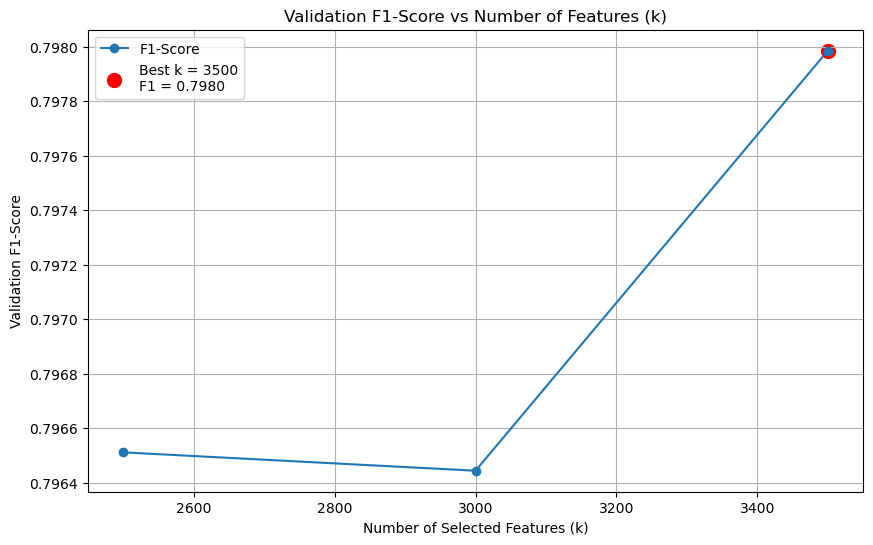

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

k_values = [2500, 3000, 3500]
f1_scores = []

X_train_features = np.abs(X_train_features)
X_val_features = np.abs(X_val_features)

for k in k_values:
    print(f"🔹 Testing k = {k}")
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_features, y_train)
    X_val_selected = selector.transform(X_val_features)
    
    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    model.fit(X_train_selected, y_train)
    
    y_val_pred = model.predict(X_val_selected)
    f1 = f1_score(y_val, y_val_pred)
    f1_scores.append(f1)
    
    print(f"✅ F1-Score with k={k}: {f1:.4f}")

best_index = np.argmax(f1_scores)
best_k = k_values[best_index]
best_f1 = f1_scores[best_index]

print("\n✨ أفضل k بناءً على Validation F1-Score:")
print(f"Best k = {best_k} with F1-Score = {best_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o', label='F1-Score')
plt.scatter(best_k, best_f1, color='red', label=f'Best k = {best_k}\nF1 = {best_f1:.4f}', s=100)
plt.title('Validation F1-Score vs Number of Features (k)')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Validation F1-Score')
plt.grid(True)
plt.legend()
plt.show()


In [18]:
from sklearn.feature_selection import SelectKBest, f_classif

k = 2000  # تقدر تغير الرقم حسب ما تحب

selector = SelectKBest(score_func=f_classif, k=k)

X_train_selected = selector.fit_transform(X_train_features, y_train)

X_val_selected = selector.transform(X_val_features)
X_test_selected = selector.transform(X_test_features)
print(X_val_selected)
print(X_test_selected)

C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4367 4368 4369 4370 4371 4372 4373 4375 4376 4377 4378 4379 4380 4381] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sheno\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[[ 5.28782369e-02  3.27367105e-01  1.05756474e-01 ... -4.76858166e+02
  -5.45097766e+02  4.53706637e+02]
 [ 1.45079971e-01  2.32454946e-01  9.49302681e-02 ... -4.52260696e+01
   5.92734023e+02  2.64895885e+02]
 [ 1.01009242e-01  1.26075385e-01  2.12994350e-01 ...  8.31323895e+01
   1.54176639e+01 -3.00515154e+02]
 ...
 [ 0.00000000e+00  8.76469455e-02  0.00000000e+00 ... -1.76099125e+02
   1.64552463e+02  3.64385282e+02]
 [ 8.52756673e-03  1.38191079e-02  4.41435215e-03 ... -2.82766546e+02
  -1.99863043e+02  3.11006046e+02]
 [ 2.32205019e-02  1.14706363e-01  7.70611540e-02 ... -1.77514473e+02
  -2.69025364e+02  3.69247642e+02]]
[[ 5.88772879e-02  1.46459543e-01  8.81127944e-02 ...  1.29014036e+01
   7.10675915e+01  1.49850028e+02]
 [ 8.85179308e-02  1.86894018e-01  1.03605637e-01 ... -2.03095630e+01
  -2.76085673e+02  1.05403583e+02]
 [ 1.04710397e-01  1.36352155e-01  4.89292936e-02 ... -2.10504858e+02
   2.46758064e+02 -9.16988032e+01]
 ...
 [ 2.08905660e-03  2.51785468e-01  1.4529346

In [19]:
print("Before selection:", X_train_features.shape[1], "features")
print("After  selection:", X_train_selected.shape[1],   "features")


Before selection: 4890 features
After  selection: 2000 features


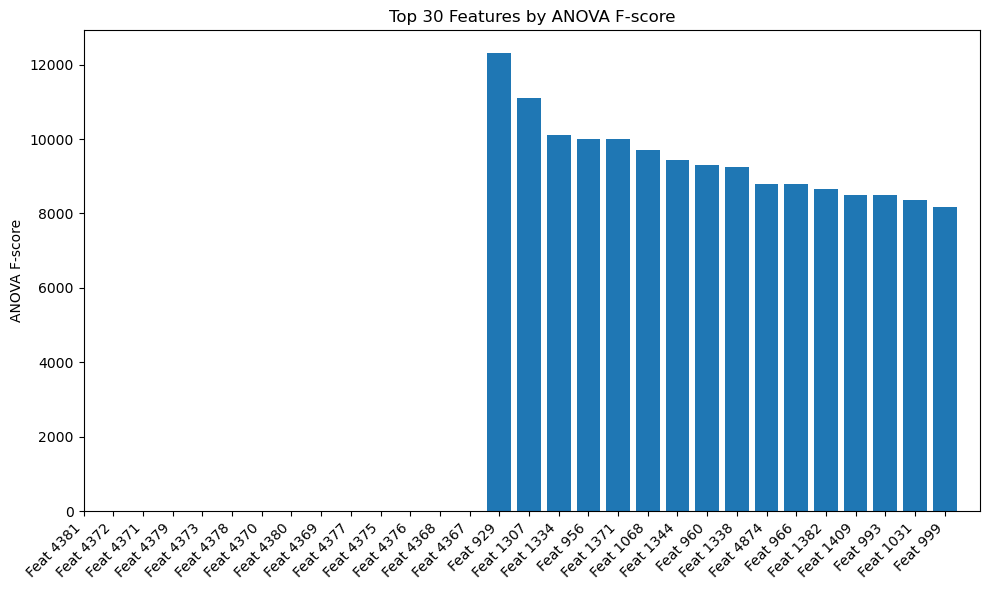

In [20]:
import matplotlib.pyplot as plt
import numpy as np

scores = selector.scores_
indices = np.argsort(scores)[::-1]

top_n = 30
top_indices = indices[:top_n]
top_scores = scores[top_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(top_n), top_scores)
plt.xticks(range(top_n), [f"Feat {i}" for i in top_indices], rotation=45, ha="right")
plt.ylabel('ANOVA F-score')
plt.title('Top 30 Features by ANOVA F-score')
plt.tight_layout()
plt.show()


In [20]:
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report

dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dval   = xgb.DMatrix(X_val_selected,   label=y_val)
dtest  = xgb.DMatrix(X_test_selected,  label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,          # ✅ قلل العمق
    'learning_rate': 0.05,
    'subsample': 0.8,     # ✅ خليه يستخدم 80% بس من الداتا كل مرة
    'nthread': -1,
    'seed': 42,
    'verbosity': 1
}

evals = [(dtrain, 'train'), (dval, 'validation')]


model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)

y_pred_prob = model.predict(dtest)
y_pred      = (y_pred_prob > 0.5).astype(int)

f1 = f1_score(y_test, y_pred)
print(f"🔹 Test F1-Score: {f1:.4f}\n")
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))


[0]	train-logloss:0.68310	validation-logloss:0.68466
[10]	train-logloss:0.61169	validation-logloss:0.62531
[20]	train-logloss:0.56707	validation-logloss:0.58915
[30]	train-logloss:0.53496	validation-logloss:0.56358
[40]	train-logloss:0.51093	validation-logloss:0.54530
[50]	train-logloss:0.49115	validation-logloss:0.53048
[60]	train-logloss:0.47502	validation-logloss:0.51874
[70]	train-logloss:0.46169	validation-logloss:0.50893
[80]	train-logloss:0.45002	validation-logloss:0.50032
[90]	train-logloss:0.43975	validation-logloss:0.49235
[100]	train-logloss:0.43020	validation-logloss:0.48532
[110]	train-logloss:0.42114	validation-logloss:0.47890
[120]	train-logloss:0.41301	validation-logloss:0.47311
[130]	train-logloss:0.40569	validation-logloss:0.46769
[140]	train-logloss:0.39893	validation-logloss:0.46275
[150]	train-logloss:0.39274	validation-logloss:0.45865
[160]	train-logloss:0.38718	validation-logloss:0.45488
[170]	train-logloss:0.38151	validation-logloss:0.45098
[180]	train-logloss:0

In [30]:
import joblib

model = joblib.load('xgboost_model.pkl')
selector = joblib.load('feature_selector.pkl')

print("the model has loaded successfully.")


تم تحميل الموديل والسلكتور بنجاح.


In [64]:
# === 7. التنبؤ على مجموعة التحقق (Validation) ===
# استخدم أفضل عدد جولات boosting اللي لقاها early stopping
best_iter = model.best_iteration  # بدل best_ntree_limit

# تنبؤ الاحتمالات باستخدام عدد الأشجار الأمثل
y_val_prob = model.predict(dval)
y_val_pred = (y_val_prob > 0.5).astype(int)

# === 8. حساب F1-Score والتقرير التصنيفي على Validation ===
from sklearn.metrics import f1_score, classification_report

f1_val = f1_score(y_val, y_val_pred)
print(f"🔹 Validation F1-Score: {f1_val:.4f}\n")
print("🔹 Validation Classification Report:")
print(classification_report(y_val, y_val_pred))


🔹 Validation F1-Score: 0.8169

🔹 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     19787
           1       0.84      0.80      0.82     19641

    accuracy                           0.82     39428
   macro avg       0.82      0.82      0.82     39428
weighted avg       0.82      0.82      0.82     39428



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# استخراج الفيتشرز من الصور
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)
X_val_features = extract_features(X_val)

# طباعة شكل الفيتشرز بعد استخراجها
print("Train features shape:", X_train_features.shape)
print("Test features shape:", X_test_features.shape)
print("Validation features shape:", X_val_features.shape)

# تعريف موديل Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,     # عدد الأشجار في الموديل
    random_state=100,     # لتثبيت العشوائية
    n_jobs=-1,            # استخدام كل الأنوية
    verbose=1             # طباعة تقدم التدريب
)

# تدريب الموديل على الفيتشرز
rf_model.fit(X_train_features, y_train)

# التقييم على بيانات الاختبار
y_test_pred = rf_model.predict(X_test_features)
y_val_pred = rf_model.predict(X_val_features)

# حساب الدقة
test_accuracy = accuracy_score(y_test, y_test_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"🔹 Test Accuracy: {test_accuracy:.4f}")
print(f"🔹 Validation Accuracy: {val_accuracy:.4f}")

# طباعة تقرير التصنيف
print("🔹 Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

print("🔹 Classification Report on Validation Data:")
print(classification_report(y_val, y_val_pred))


Train features shape: (140002, 4890)
Test features shape: (10905, 4890)
Validation features shape: (39428, 4890)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 33.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    6.9s finis

🔹 Test Accuracy: 0.7208
🔹 Validation Accuracy: 0.8061
🔹 Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      5413
           1       0.69      0.81      0.74      5492

    accuracy                           0.72     10905
   macro avg       0.73      0.72      0.72     10905
weighted avg       0.73      0.72      0.72     10905

🔹 Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     19787
           1       0.81      0.80      0.81     19641

    accuracy                           0.81     39428
   macro avg       0.81      0.81      0.81     39428
weighted avg       0.81      0.81      0.81     39428

